In [54]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import pandas as pd
import pickle as pkl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats
from src.config import get_interim_dir
from skbio.stats.composition import clr

from src.config import get_hussmann_supplementary_xlsx, HOME_PATH, PROFILE_TYPE, TARGET, SAMPLE, FILTER_COUNT, METHOD, get_experiment_artifacts


In [56]:
PROFILE_TYPE, FILTER_COUNT, METHOD

('paired-replicates', 700, 'robust_cov')

In [57]:
results_df = pd.read_pickle(get_experiment_artifacts() + "outlier_results.pkl")
results_df

Sample               T1                   T2                   T3           
Measure         pvalues  distances   pvalues  distances   pvalues  distances
Gene                                                                        
0610009B22Rik  0.999409   0.169394  0.733467   2.782549  0.286750   6.205324
0610010K14Rik  0.922053   1.420544  0.731721   2.793915  0.719807   2.871384
0610030E20Rik  0.151195   8.092794  0.684153   3.102720  0.583620   3.765686
0610040J01Rik  0.027328  12.609331  0.233254   6.834351  0.011028  14.848909
1110004F10Rik  0.096137   9.343101  0.283318   6.242655  0.049514  11.095744
...                 ...        ...       ...        ...       ...        ...
Znhit1              NaN        NaN  0.019401  13.463578  0.104563   9.115033
Zranb2              NaN        NaN  0.033617  12.086810  0.002018  18.886149
Zrsr1               NaN        NaN  0.400979   5.123631  0.047869  11.183051
Zup1                NaN        NaN  0.116112   8.828292  0.489857   4.425913
Zwilch              NaN        NaN  0.372210   5.371785  0.027703  12.575072

[18078 rows x 6 columns]

In [58]:
score_df = results_df.dropna()
score_df = pd.DataFrame(StandardScaler().fit_transform(score_df.xs("distances", level="Measure", axis=1)), columns=score_df.columns.unique(level=0), index=score_df.index)
score_df.loc[:,"Max Score"] = score_df.max(axis=1)
score_df.loc[:,"Mean Score"] = score_df.mean(axis=1)
score_df.head()

Sample,T1,T2,T3,Max Score,Mean Score
Gene,,,,,
0610009B22Rik,-0.747848,-0.512369,-0.202316,-0.202316,-0.416213
0610010K14Rik,-0.644942,-0.511269,-0.506267,-0.506267,-0.542186
0610030E20Rik,-0.096154,-0.481390,-0.424735,-0.096154,-0.274608
0610040J01Rik,0.275328,-0.120329,0.585708,0.585708,0.331603
1110004F10Rik,0.006683,-0.177580,0.243536,0.243536,0.079044


### Missing gene data per sample.

In [59]:
results_df.isna().any(axis=1).sum()

1834

In [60]:
psuedo_controls = score_df.dropna().sort_values("Mean Score").iloc[:100,0].index.to_list()
print(psuedo_controls[:5])

pd.Series(psuedo_controls).to_csv("{}/psuedo_controls.txt".format(get_experiment_artifacts()), index=False)

aliases = ["MB0{}".format(i) for i in range(1,7)]
print(aliases)

X_imputed_target = pkl.load(open("{}/imputed_sample_data.pkl".format(get_experiment_artifacts(profile_type = "target")), "rb"))
print("Data Ready.")

X_imputed_sample = pkl.load(open("{}/imputed_sample_data.pkl".format(get_experiment_artifacts(profile_type = "sample")), "rb"))
print("Data Ready.")

['Gnas', 'Cdc14a', 'Espn', 'Speg', 'Slc4a8']
['MB01', 'MB02', 'MB03', 'MB04', 'MB05', 'MB06']
Data Ready.
Data Ready.


In [61]:
results_df

Sample               T1                   T2                   T3           
Measure         pvalues  distances   pvalues  distances   pvalues  distances
Gene                                                                        
0610009B22Rik  0.999409   0.169394  0.733467   2.782549  0.286750   6.205324
0610010K14Rik  0.922053   1.420544  0.731721   2.793915  0.719807   2.871384
0610030E20Rik  0.151195   8.092794  0.684153   3.102720  0.583620   3.765686
0610040J01Rik  0.027328  12.609331  0.233254   6.834351  0.011028  14.848909
1110004F10Rik  0.096137   9.343101  0.283318   6.242655  0.049514  11.095744
...                 ...        ...       ...        ...       ...        ...
Znhit1              NaN        NaN  0.019401  13.463578  0.104563   9.115033
Zranb2              NaN        NaN  0.033617  12.086810  0.002018  18.886149
Zrsr1               NaN        NaN  0.400979   5.123631  0.047869  11.183051
Zup1                NaN        NaN  0.116112   8.828292  0.489857   4.425913
Zwilch              NaN        NaN  0.372210   5.371785  0.027703  12.575072

[18078 rows x 6 columns]

In [62]:
from scipy import stats

results_df_nona = results_df.dropna()
try:
    ss = StandardScaler().fit(results_df_nona.xs("distances", level="Measure", axis=1))
    score_df = pd.DataFrame(ss.transform(results_df.xs("distances", level="Measure", axis=1)), columns=aliases, index=results_df.index)
except: 
    ss = StandardScaler().fit(results_df_nona.xs("distances", level="Measure", axis=1))
    score_df = pd.DataFrame(ss.transform(results_df.xs("distances", level="Measure", axis=1)), columns=results_df.columns.unique(level="Sample"), index=results_df.index)
results_df.loc[:,("Global", "Max Score")] = score_df.max(axis=1)
results_df.loc[:,("Global", "Mean Score")] = score_df.mean(axis=1, skipna=True)


In [63]:
psuedo_controls = results_df.dropna().sort_values(by=("Global", "Mean Score")).iloc[:100,:].index.to_series()
psuedo_controls.head()

Gene
Gnas        Gnas
Cdc14a    Cdc14a
Espn        Espn
Speg        Speg
Tmcc2      Tmcc2
Name: Gene, dtype: object

In [64]:
df = pd.concat(X_imputed_sample.values(), keys=X_imputed_sample.keys(), names=["Sample"])
print(df.shape)

# outliers_df = df[df.index.get_level_values("Gene").isin(outliers)]
# print(outliers_df.shape)

psudo_control_df = df.loc[df.index.get_level_values("Gene").isin(psuedo_controls), :]
psudo_control_gmean_df = pd.DataFrame(psudo_control_df.groupby("Sample").apply(stats.gmean).values.tolist(), index=X_imputed_sample.keys(), columns=df.columns)
psudo_control_gmean_df.index.name="Sample"
psudo_control_gmean_df

psudo_control_gmean_df = psudo_control_gmean_df.div(psudo_control_gmean_df.sum(axis=1), axis=0)

print(psudo_control_gmean_df.shape)

change_df = df - psudo_control_gmean_df
change_df
print(change_df.shape)

clr_change_df = {}

# mapping = {
#     "MB01": "T1",
#     "MB02": "T1",
#     "MB03": "T2",
#     "MB04": "T2",
#     "MB05": "T3",
#     "MB06": "T3",
# }

for alias in aliases:
    clrcdf = df.loc[alias, :] .dropna(axis=1)
    clrcdf = pd.DataFrame(clr(clrcdf), index=clrcdf.index, columns=clrcdf.columns)
    clr_change_df[alias] = (clrcdf - clr(psudo_control_gmean_df.loc[alias, :].dropna()))

clr_change_df = pd.concat(clr_change_df)

(104800, 7)
(6, 7)
(104800, 7)


In [65]:
def consistency(x, change_df, sample1, sample2, method="pearson"):
    if (sample1, x) not in change_df.index:
        return np.nan

    if (sample2, x) not in change_df.index:
        return np.nan

    if method == "spearman":
        return stats.spearmanr(change_df.loc[(sample1, x),:].dropna(), change_df.loc[(sample2, x),:].dropna())[0]
    if method == "pearson":
        return stats.pearsonr(change_df.loc[(sample1, x),:].dropna(), change_df.loc[(sample2, x),:].dropna())[0]

In [66]:
# def consistency(x, change_df, sample1, sample2):
#     if (sample1, x) not in change_df.index:
#         return np.nan

#     if (sample2, x) not in change_df.index:
#         return np.nan

#     idx = pd.IndexSlice
#     z=np.array([1,1])
#     xy = change_df.loc[idx[[sample1, sample2], x], :].T.dropna().values

#     return np.sum(np.square(np.cross(z,xy)/np.linalg.norm(z)))



results_df.loc[:,("T1", "CLR Consistency")] = results_df.index.to_series().apply(lambda x: consistency(x, clr_change_df, "MB01", "MB02"))
results_df.loc[:,("T2", "CLR Consistency")] = results_df.index.to_series().apply(lambda x: consistency(x, clr_change_df, "MB03", "MB04"))
results_df.loc[:,("T3", "CLR Consistency")] = results_df.index.to_series().apply(lambda x: consistency(x, clr_change_df, "MB05", "MB06"))


results_df.loc[:,("T1", "Consistency")] = results_df.index.to_series().apply(lambda x: consistency(x, change_df, "MB01", "MB02"))
results_df.loc[:,("T2", "Consistency")] = results_df.index.to_series().apply(lambda x: consistency(x, change_df, "MB03", "MB04"))
results_df.loc[:,("T3", "Consistency")] = results_df.index.to_series().apply(lambda x: consistency(x, change_df, "MB05", "MB06"))

results_df.loc[:,("Global", "Mean Consistency")] = np.nanmean(results_df.xs("Consistency", level="Measure", axis=1), axis=1)
results_df.loc[:,("Global", "Mean Std Consistency")] = np.nanmean(StandardScaler().fit_transform(results_df.xs("Consistency", level="Measure", axis=1)), axis=1)
results_df.loc[:,("Global", "Mean Std CLR Consistency")] = np.nanmean(StandardScaler().fit_transform(results_df.xs("CLR Consistency", level="Measure", axis=1)), axis=1)

In [67]:
results_df = results_df.sort_index(axis=1)
results_df.head()

Sample           Global                                                       \
Measure       Max Score Mean Consistency Mean Score Mean Std CLR Consistency   
Gene                                                                           
0610009B22Rik -0.202316        -0.263600  -0.487511                -0.864817   
0610010K14Rik -0.506267         0.404967  -0.554160                 0.147015   
0610030E20Rik -0.096154         0.068685  -0.334093                -0.104114   
0610040J01Rik  0.585708         0.337484   0.246902                -0.339103   
1110004F10Rik  0.243536        -0.194733   0.024213                -0.119202   

Sample                                          T1                         \
Measure       Mean Std Consistency CLR Consistency Consistency  distances   
Gene                                                                        
0610009B22Rik            -0.918179       -0.849354   -0.897694   0.169394   
0610010K14Rik             0.639911        0.689295    0.672534   1.420544   
0610030E20Rik            -0.108152        0.366741    0.528662   8.092794   
0610040J01Rik             0.485153        0.380555    0.580776  12.609331   
1110004F10Rik            -0.727883       -0.216158   -0.155832   9.343101   

Sample                               T2                                  \
Measure         pvalues CLR Consistency Consistency distances   pvalues   
Gene                                                                      
0610009B22Rik  0.999409       -0.074988    0.184059  2.782549  0.733467   
0610010K14Rik  0.922053       -0.149701   -0.019421  2.793915  0.731721   
0610030E20Rik  0.151195       -0.132531   -0.043404  3.102720  0.684153   
0610040J01Rik  0.027328       -0.650751   -0.067379  6.834351  0.233254   
1110004F10Rik  0.096137        0.086380   -0.054858  6.242655  0.283318   

Sample                     T3                                   
Measure       CLR Consistency Consistency  distances   pvalues  
Gene                                                            
0610009B22Rik        0.141639   -0.077164   6.205324  0.286750  
0610010K14Rik       -0.117280    0.561789   2.871384  0.719807  
0610030E20Rik       -0.118037   -0.279202   3.765686  0.583620  
0610040J01Rik        0.090293    0.499054  14.848909  0.011028  
1110004F10Rik        0.283791   -0.373509  11.095744  0.049514

In [68]:
results_df[("T1", "Consistency")].dropna().sort_values(ascending=False)

Gene
Trp53      0.989460
Mettl3     0.989262
Dhx15      0.988095
Tie1       0.984422
Htr2b      0.982076
             ...   
Abcb1a    -0.953672
Lrrc24    -0.960214
Sox11     -0.962866
Mogat1    -0.963219
Tmem232   -0.975624
Name: (T1, Consistency), Length: 16432, dtype: float64

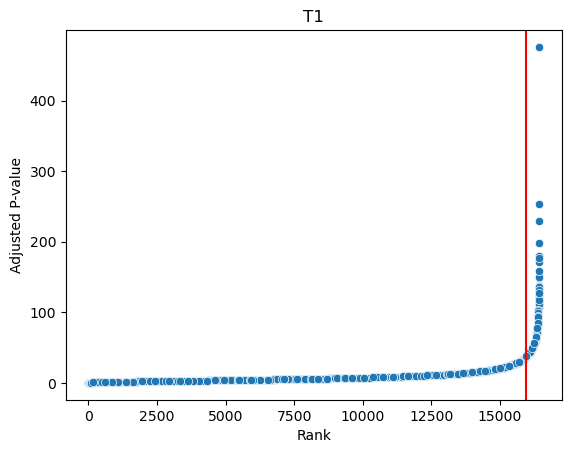

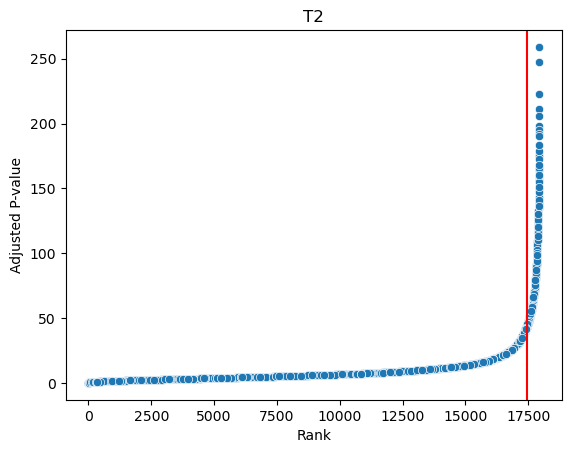

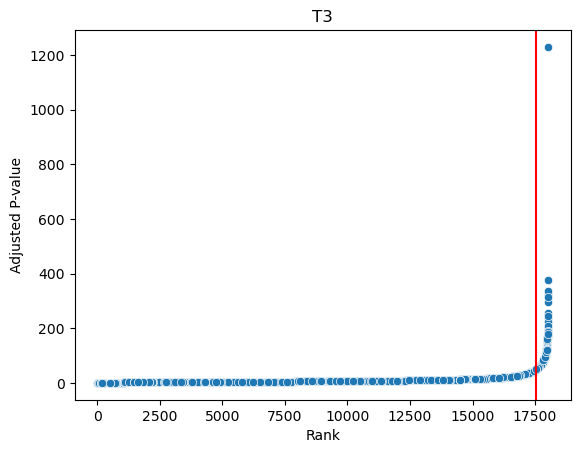

In [69]:
if PROFILE_TYPE == SAMPLE:
    ts = ["MB01", "MB02", "MB03", "MB04", "MB05", "MB06"]
else:
    ts = ["T1", "T2", "T3"]

for t in ts:
    y = results_df.loc[:,(t, "distances")]
    x = y.rank()
    plt.figure()
    sns.scatterplot(x=x, y=y)
    plt.xlabel("Rank")
    plt.ylabel("Adjusted P-value")
    plt.axvline(x.max()-500, c="red")
    plt.title(t)
    plt.savefig("{}/rankvsscore{}.png".format(get_experiment_artifacts(), t))
    plt.show()


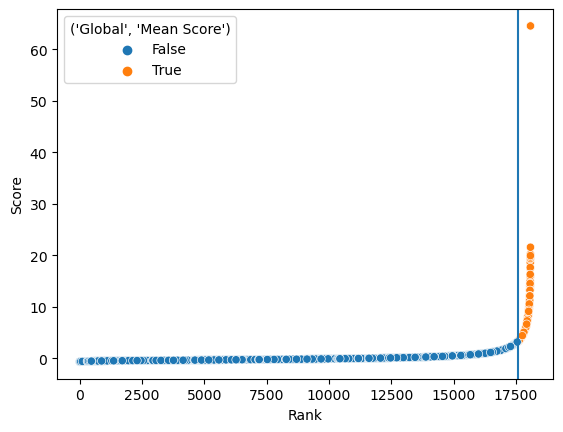

In [70]:
measure = "Mean Score"

y = results_df.loc[:,("Global", "Mean Score")]
x = y.rank()
sns.scatterplot(x=x, y=y, hue=x > y.rank().max()-500)
plt.xlabel("Rank")
plt.ylabel("Score")
plt.axvline(y.rank().max()-500)
plt.savefig("{}/rankvsscore.png".format(get_experiment_artifacts()))

<AxesSubplot: xlabel='Distances', ylabel='Density'>

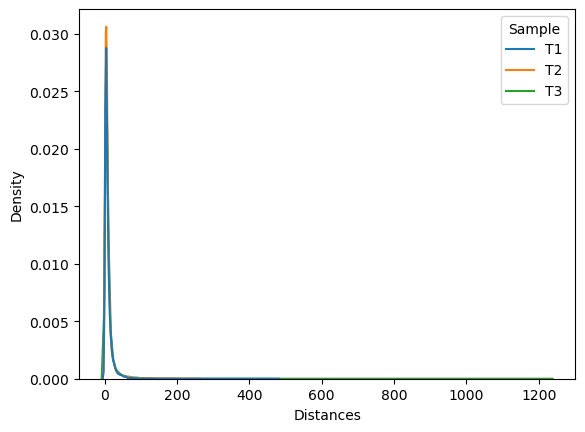

In [71]:
sns.kdeplot(data=results_df.xs("distances", level="Measure", axis=1).stack().reset_index().rename(columns={0: "Distances"}), x="Distances", hue="Sample")

In [72]:
results_df

Sample           Global                                                       \
Measure       Max Score Mean Consistency Mean Score Mean Std CLR Consistency   
Gene                                                                           
0610009B22Rik -0.202316        -0.263600  -0.487511                -0.864817   
0610010K14Rik -0.506267         0.404967  -0.554160                 0.147015   
0610030E20Rik -0.096154         0.068685  -0.334093                -0.104114   
0610040J01Rik  0.585708         0.337484   0.246902                -0.339103   
1110004F10Rik  0.243536        -0.194733   0.024213                -0.119202   
...                 ...              ...        ...                      ...   
Znhit1         0.521094         0.083298   0.292026                 1.047208   
Zranb2         0.953777         0.065813   0.670830                 0.916843   
Zrsr1          0.251496        -0.220415  -0.017179                -0.678197   
Zup1           0.072598        -0.140818  -0.145972                -0.724366   
Zwilch         0.378405         0.195067   0.058281                -0.341709   

Sample                                          T1                         \
Measure       Mean Std Consistency CLR Consistency Consistency  distances   
Gene                                                                        
0610009B22Rik            -0.918179       -0.849354   -0.897694   0.169394   
0610010K14Rik             0.639911        0.689295    0.672534   1.420544   
0610030E20Rik            -0.108152        0.366741    0.528662   8.092794   
0610040J01Rik             0.485153        0.380555    0.580776  12.609331   
1110004F10Rik            -0.727883       -0.216158   -0.155832   9.343101   
...                            ...             ...         ...        ...   
Znhit1                   -0.055802             NaN         NaN        NaN   
Zranb2                   -0.120845             NaN         NaN        NaN   
Zrsr1                    -0.742873             NaN         NaN        NaN   
Zup1                     -0.572357             NaN         NaN        NaN   
Zwilch                    0.184709             NaN         NaN        NaN   

Sample                               T2                                   \
Measure         pvalues CLR Consistency Consistency  distances   pvalues   
Gene                                                                       
0610009B22Rik  0.999409       -0.074988    0.184059   2.782549  0.733467   
0610010K14Rik  0.922053       -0.149701   -0.019421   2.793915  0.731721   
0610030E20Rik  0.151195       -0.132531   -0.043404   3.102720  0.684153   
0610040J01Rik  0.027328       -0.650751   -0.067379   6.834351  0.233254   
1110004F10Rik  0.096137        0.086380   -0.054858   6.242655  0.283318   
...                 ...             ...         ...        ...       ...   
Znhit1              NaN        0.612933    0.664153  13.463578  0.019401   
Zranb2              NaN        0.351070   -0.176781  12.086810  0.033617   
Zrsr1               NaN       -0.582349    0.044216   5.123631  0.400979   
Zup1                NaN       -0.206005   -0.095072   8.828292  0.116112   
Zwilch              NaN        0.194251    0.502520   5.371785  0.372210   

Sample                     T3                                   
Measure       CLR Consistency Consistency  distances   pvalues  
Gene                                                            
0610009B22Rik        0.141639   -0.077164   6.205324  0.286750  
0610010K14Rik       -0.117280    0.561789   2.871384  0.719807  
0610030E20Rik       -0.118037   -0.279202   3.765686  0.583620  
0610040J01Rik        0.090293    0.499054  14.848909  0.011028  
1110004F10Rik        0.283791   -0.373509  11.095744  0.049514  
...                       ...         ...        ...       ...  
Znhit1               0.474388   -0.497556   9.115033  0.104563  
Zranb2               0.631090    0.308406  18.886149  0.002018  
Zrsr1               

In [73]:
hussmann_repair_genes = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)["Gene"].str.capitalize()
print(hussmann_repair_genes.shape)
print(hussmann_repair_genes.head())
genesubsetSD30 = pd.read_csv(HOME_PATH + "/repos/MUSICian/src/data/GeneSubsetSD30.txt", sep="\t")["Gene"]
print(genesubsetSD30.shape)
print(genesubsetSD30.head())
genesubset2 = pd.read_csv(HOME_PATH + "/repos/MUSICian/src/data/GeneSubset2.txt", sep="\t")["Gene"]
print(genesubset2.shape)
print(genesubset2.head())

(476,)
0    Actl6a
1     Actr5
2     Actr8
3     Aicda
4    Alkbh2
Name: Gene, dtype: object
(628,)
0       Cenpq
1    Trp53bp1
2    Vmn2r112
3        Cd36
4     Cysltr2
Name: Gene, dtype: object
(52,)
0        Dut
1    Faap100
2      Fanca
3      Fancb
4      Fancc
Name: Gene, dtype: object


In [74]:
results_df[("Gene Sets", "Adamson")] = results_df.index.isin(hussmann_repair_genes)
results_df[("Gene Sets", "GeneSubset2")] = results_df.index.isin(genesubset2)
results_df[("Gene Sets", "GeneSubsetSD30")] = results_df.index.isin(genesubsetSD30)

In [75]:
results_df

Sample           Global                                                       \
Measure       Max Score Mean Consistency Mean Score Mean Std CLR Consistency   
Gene                                                                           
0610009B22Rik -0.202316        -0.263600  -0.487511                -0.864817   
0610010K14Rik -0.506267         0.404967  -0.554160                 0.147015   
0610030E20Rik -0.096154         0.068685  -0.334093                -0.104114   
0610040J01Rik  0.585708         0.337484   0.246902                -0.339103   
1110004F10Rik  0.243536        -0.194733   0.024213                -0.119202   
...                 ...              ...        ...                      ...   
Znhit1         0.521094         0.083298   0.292026                 1.047208   
Zranb2         0.953777         0.065813   0.670830                 0.916843   
Zrsr1          0.251496        -0.220415  -0.017179                -0.678197   
Zup1           0.072598        -0.140818  -0.145972                -0.724366   
Zwilch         0.378405         0.195067   0.058281                -0.341709   

Sample                                          T1                         \
Measure       Mean Std Consistency CLR Consistency Consistency  distances   
Gene                                                                        
0610009B22Rik            -0.918179       -0.849354   -0.897694   0.169394   
0610010K14Rik             0.639911        0.689295    0.672534   1.420544   
0610030E20Rik            -0.108152        0.366741    0.528662   8.092794   
0610040J01Rik             0.485153        0.380555    0.580776  12.609331   
1110004F10Rik            -0.727883       -0.216158   -0.155832   9.343101   
...                            ...             ...         ...        ...   
Znhit1                   -0.055802             NaN         NaN        NaN   
Zranb2                   -0.120845             NaN         NaN        NaN   
Zrsr1                    -0.742873             NaN         NaN        NaN   
Zup1                     -0.572357             NaN         NaN        NaN   
Zwilch                    0.184709             NaN         NaN        NaN   

Sample                               T2                                   \
Measure         pvalues CLR Consistency Consistency  distances   pvalues   
Gene                                                                       
0610009B22Rik  0.999409       -0.074988    0.184059   2.782549  0.733467   
0610010K14Rik  0.922053       -0.149701   -0.019421   2.793915  0.731721   
0610030E20Rik  0.151195       -0.132531   -0.043404   3.102720  0.684153   
0610040J01Rik  0.027328       -0.650751   -0.067379   6.834351  0.233254   
1110004F10Rik  0.096137        0.086380   -0.054858   6.242655  0.283318   
...                 ...             ...         ...        ...       ...   
Znhit1              NaN        0.612933    0.664153  13.463578  0.019401   
Zranb2              NaN        0.351070   -0.176781  12.086810  0.033617   
Zrsr1               NaN       -0.582349    0.044216   5.123631  0.400979   
Zup1                NaN       -0.206005   -0.095072   8.828292  0.116112   
Zwilch              NaN        0.194251    0.502520   5.371785  0.372210   

Sample                     T3                                  Gene Sets  \
Measure       CLR Consistency Consistency  distances   pvalues   Adamson   
Gene                                                                       
0610009B22Rik        0.141639   -0.077164   6.205324  0.286750     False   
0610010K14Rik       -0.117280    0.561789   2.871384  0.719807     False   
0610030E20Rik       -0.118037   -0.279202   3.765686  0.583620     False   
0610040J01Rik        0.090293    0.499054  14.848909  0.011028     False   
1110004F10Rik        0.283791   -0.373509  11.095744  0.049514     False   
...                       ...         ...        ...       ...       ...   
Znhit1               0.474388   -0.497556   9.11503

In [76]:
results_df.to_pickle(get_experiment_artifacts() + "augmented_outlier_results.pkl")